<a href="https://colab.research.google.com/github/Taimaaaa/Resampling-Datetime-Data/blob/main/Resampling_Datetime_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resampling Datetime Data

- Author: Taima Nasser

##Imports & Loading

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns
from matplotlib.ticker import NullFormatter

sns.set_context("talk", font_scale=0.9)
plt.rcParams['figure.figsize'] = (12,4)

In [186]:
df = pd.read_csv("london_weather_MODIFIED - london_weather_MODIFIED.csv")
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


##Convert date column to datetime

In [187]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d", errors='coerce')
df = df.dropna(subset=['date'])
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [188]:
#setting new date as index
df = df.set_index('date')
df = df.sort_index()

In [189]:
df.index.min(), df.index.max()

(Timestamp('1979-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

##Filtering Dataset

In [190]:
#filter from year 2000 onward
df = df.loc['2000':]
df.head()

#keep only required features
features = [
    'precipitation',
    'mean_temp',
    'min_temp',
    'max_temp',
    'snow_depth'
]

df = df[features].copy()
df.head()


,precipitation,mean_temp,min_temp,max_temp,snow_depth
date,,,,,
2000-01-01,0.0,7.0,4.9,10.8,0.0
2000-01-02,0.2,7.9,5.0,11.5,0.0
2000-01-03,6.0,9.4,7.2,9.5,0.0
2000-01-04,0.2,7.0,4.4,11.0,0.0
2000-01-05,0.8,6.4,1.9,10.8,0.0


##Handling Missing Values

In [191]:
df.isna().sum()

,0
precipitation,390
mean_temp,419
min_temp,386
max_temp,390
snow_depth,1752


In [192]:
df_clean = df.copy()

# precipitation: missing = 0
df_clean['precipitation'] = df_clean['precipitation'].fillna(0)

# temperatures: smooth values, use interpolate
df_clean['mean_temp'] = df_clean['mean_temp'].interpolate()
df_clean['min_temp'] = df_clean['min_temp'].interpolate()
df_clean['max_temp'] = df_clean['max_temp'].interpolate()

# snow depth: accumulates → forward fill then interpolate
df_clean['snow_depth'] = df_clean['snow_depth'].fillna(method="ffill")
df_clean['snow_depth'] = df_clean['snow_depth'].interpolate()

df_clean.isna().sum()

/tmp/ipython-input-1194125767.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean['snow_depth'] = df_clean['snow_depth'].fillna(method="ffill")


,0
precipitation,0
mean_temp,0
min_temp,0
max_temp,0
snow_depth,0


##Vis of what month had the most precipitation between 2000 through 2010?

In [193]:
# restrict to 2000–2010
df_q1 = df_clean.loc['2000':'2010']

# monthly precipitation totals
prec_monthly = df_q1['precipitation'].resample("MS").sum()
prec_monthly.head()

,precipitation
date,
2000-01-01,14.3
2000-02-01,62.2
2000-03-01,13.4
2000-04-01,71.8
2000-05-01,68.4


In [194]:
# find max precipitation month
max_date = prec_monthly.idxmax()
max_value = prec_monthly.max()

max_date, max_value

(Timestamp('2009-11-01 00:00:00'), 138.4)

In [195]:
df_clean.index.min(), df_clean.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

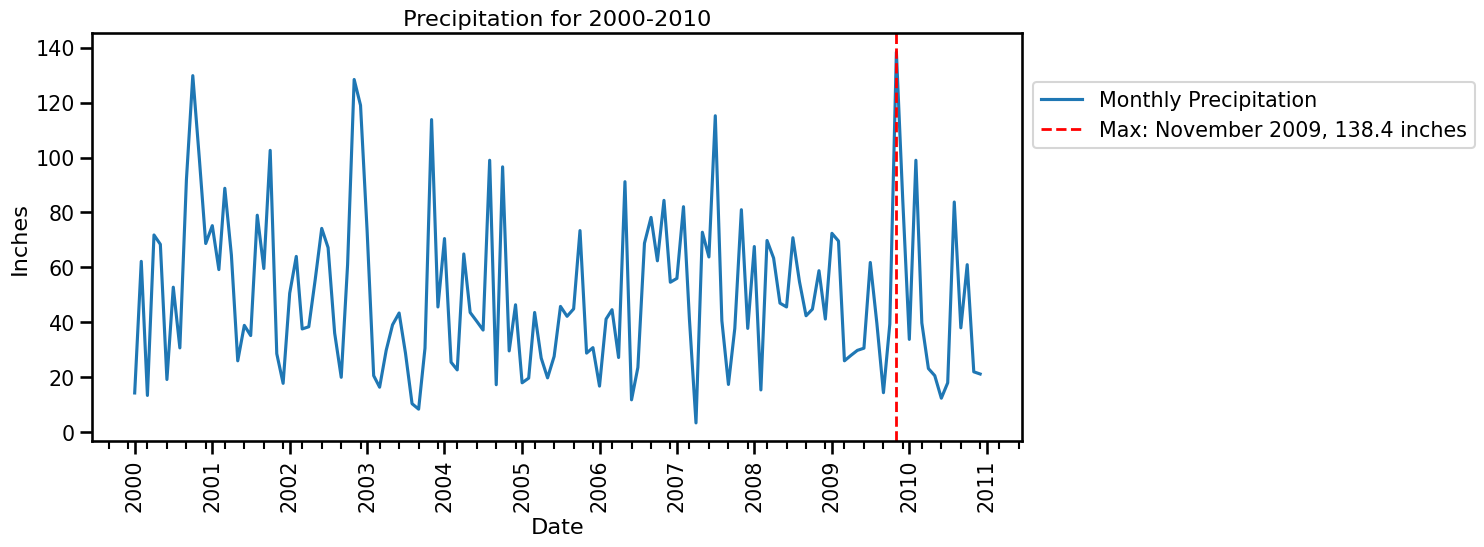

In [196]:
# ceate a wide figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# use ax.plot() directly passing x (index) and y (values)
ax.plot(prec_monthly.index, prec_monthly.values, label='Monthly Precipitation')

# apply general plot customizations
ax.set_title('Precipitation for 2000-2010')
ax.set_ylabel('Inches')
ax.set_xlabel('Date')

# customize the major x-axis ticks (using positional 'base' argument)
major_locator = mdates.YearLocator(1)
ax.xaxis.set_major_locator(major_locator)
major_formatter = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(major_formatter)

# customize the minor x-axis ticks
minor_locator = mdates.MonthLocator(interval=3)
ax.xaxis.set_minor_locator(minor_locator)
ax.xaxis.set_minor_formatter(NullFormatter())

# add vertical line and label
label_text = max_date.strftime('%B %Y')
ax.axvline(x=max_date, color='r', linestyle='--', linewidth=2,
           label=f'Max: {label_text}, {max_value:.1f} inches')

# add the legend and auto-format the dates
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.autofmt_xdate(rotation=90, ha='center')

# display the plot
plt.show()

##Vis for Coolest Average Temperature (2000–2020)

In [197]:
# restrict to 2000–2020
df_q2 = df_clean.loc['2000':'2020'].copy()

# yearly average temperature
yearly_temp = df_q2['mean_temp'].resample("Y").mean()
yearly_temp.head()

/tmp/ipython-input-2404529314.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_temp = df_q2['mean_temp'].resample("Y").mean()


,mean_temp
date,
2000-12-31,11.575683
2001-12-31,11.331507
2002-12-31,12.084247
2003-12-31,12.114521
2004-12-31,11.900683


In [198]:
#finding min avg temp
min_year = yearly_temp.idxmin()
min_temp = yearly_temp.min()

min_year, min_temp


(Timestamp('2010-12-31 00:00:00'), 10.657397260273973)

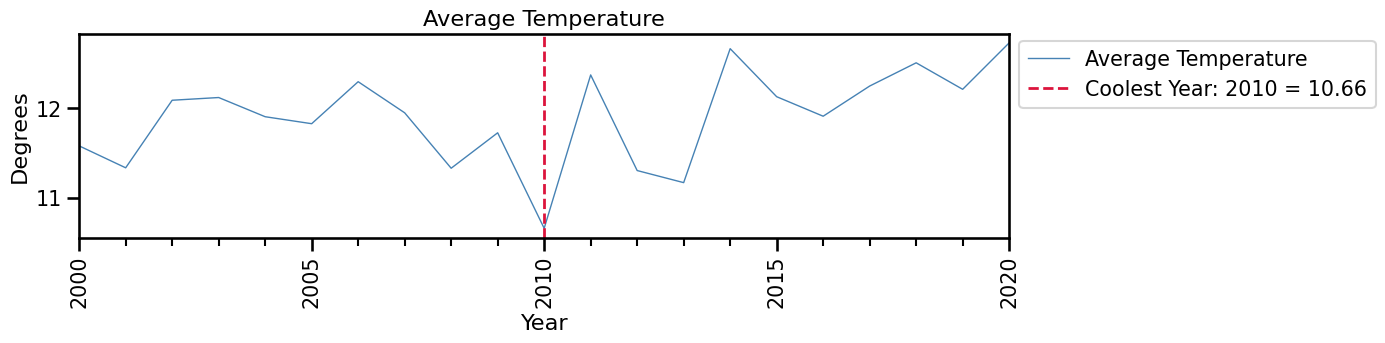

In [199]:
fig, ax = plt.subplots(figsize=(12, 3))

yearly_temp.plot(ax=ax, lw=1, label='Average Temperature', color='steelblue')

ax.set_title("Average Temperature")
ax.set_ylabel("Degrees")
ax.set_xlabel("Year")

# force correct X-axis limits BEFORE setting ticks
ax.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2020-12-31"))

#  Major ticks every 5 years
years = pd.date_range('2000', '2020', freq='YS')
major_years = years[years.year % 5 == 0]
ax.set_xticks(major_years)
ax.set_xticklabels(major_years.strftime("%Y"))

# Minor ticks every 1 year (unlabeled)
ax.set_xticks(years, minor=True)
ax.xaxis.set_minor_formatter(NullFormatter())

#  Vertical line for coolest year
label = min_year.strftime("%Y")
ax.axvline(min_year, color='crimson', ls='--', lw=2,
           label=f"Coolest Year: {label} = {min_temp:.2f}")

# rotate ticks
fig.autofmt_xdate(rotation=90, ha='center')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

plt.show()
